把tensor转换成图片
```python
from PIL import Image
image_np = control_image[0].permute(1, 2, 0).numpy()
image_np_uint8 = (image_np * 255).astype(np.uint8)
image = Image.fromarray(image_np_uint8)
image.show()
```

In [1]:
import torch
import os
from diffusers.utils import load_image
from PIL import Image
import numpy as np
from diffusers import (
    ControlNetModel,
    StableDiffusionControlNetPipeline,
    UniPCMultistepScheduler,
)

In [13]:
def reshape_size(filepath,size=512):
    image = load_image(filepath)
    image = image.resize((size,size))
    image.save(filepath)

In [6]:
checkpoint = "lllyasviel/control_v11p_sd15_inpaint"
original_image = load_image(
    "./data/image.jpg.png"
)
mask_image = load_image(
    "./data/image.jpg (1).png"
)

In [4]:
def make_inpaint_condition(image, image_mask):
    image = np.array(image.convert("RGB")).astype(np.float32) / 255.0
    image_mask = np.array(image_mask.convert("L"))
    assert image.shape[0:1] == image_mask.shape[0:1], "image and image_mask must have the same image size"
    image[image_mask < 128] = -1.0 # set as masked pixel 
    preview_image = Image.fromarray(np.uint8(image*255))
    image = np.expand_dims(image, 0).transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return image, preview_image

In [7]:
control_image, preview_image = make_inpaint_condition(original_image, mask_image)

In [8]:
prompt = "best quality"
negative_prompt="lowres, bad anatomy, bad hands, cropped, worst quality"
controlnet = ControlNetModel.from_pretrained(checkpoint, torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
generator = torch.manual_seed(2)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
d:\anaconda3\envs\huggingface\lib\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [9]:
image = pipe(prompt, negative_prompt=negative_prompt, num_inference_steps=30, generator=generator, image=control_image).images[0]

  0%|          | 0/30 [00:00<?, ?it/s]

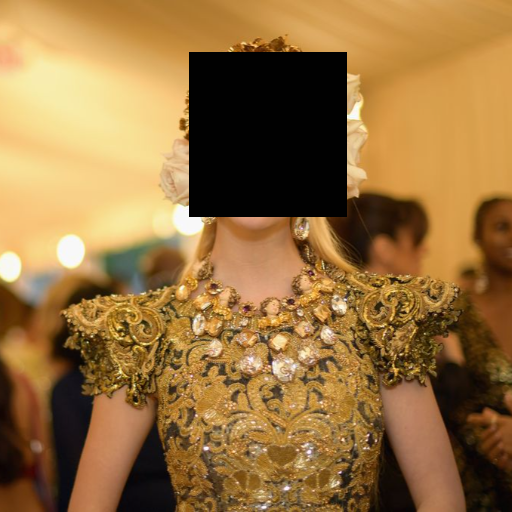

In [10]:
preview_image

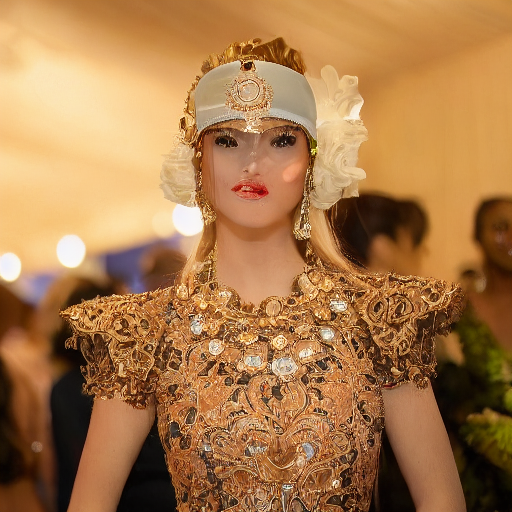

In [11]:
image